In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [20]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")

print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [21]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set to length 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
train_true_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), -7:].values)
print(train_v.shape)
print(train_v.shape[0]/28)
print(train_true_v.shape)
print(train_true_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
(2520000, 7)
90000.0


In [22]:
# set up test set
test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)
test_true_v = copy.deepcopy(test_df.iloc[:, -7:].values)
print("TCHDL:", test_df.columns.get_loc('TCHDL'))
print(test_v.shape)
print(test_v.shape[0]/28)
print(test_true_v.shape)
print(test_true_v.shape[0]/28)

Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096
TCHDL: 14
(282688, 182)
10096.0
(282688, 7)
10096.0


In [23]:
print(view_1hot_df.columns.get_loc('TCHDL'))
print(test_df.columns.get_loc('TCHDL'))

14
14


In [24]:
def get_mean_TCHDL(train_v):
    mean_tchdl = []
    num_of_inds = train_v.shape[0]//28
    for i in range(num_of_inds):
        ind_v = train_v[(i*28):((i+1)*28), :]
        ind_tchdl = np.mean(ind_v[8:28, 14])
        mean_tchdl.append(ind_tchdl)
    print(len(mean_tchdl)) 
    return np.array([mean_tchdl]).T

In [25]:
def setup_x(scaled_time_series):
    num_of_inds = scaled_time_series.shape[0]//28
    n_features = scaled_time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*7), 
                   dtype='float')
    ###############################################
    # construct x  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        scaled_ind_v = copy.deepcopy(scaled_time_series[(i*28):((i+1)*28), :])
        _x[i, :n_features] = copy.deepcopy(scaled_ind_v[0, :])
        for j in range(1, 8):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(scaled_ind_v[j, 1:])
    return _x

In [26]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
#################################
#  x
#################################
scaler_x = StandardScaler()
scaled_train = scaler_x.fit_transform(train_v) 
scaled_test = scaler_x.transform(test_v)
x_train = setup_x(scaled_train)
x_test = setup_x(scaled_test)
#################################
#  y
#################################
scaler_y = StandardScaler()
mean_tchdl_train = get_mean_TCHDL(train_v)

y_train = scaler_y.fit_transform(mean_tchdl_train)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

90000
(90000, 1449)
(10096, 1449)
(90000, 1)


In [27]:
def setup_model(n_units, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', 
                    #kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(1449, ))) #1449, 1457
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(n_units, activation='relu'))
                    #kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(1)) 
                   #kernel_regularizer=regularizers.l2(0.01)))
    #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4)  #1e-4
    model.compile(loss='mae', optimizer='adam')
    return model

In [28]:
def fit_model(model, X_train, Y_train, b_size):
    val_weight = "MLP_val_weights.hdf5"
    val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                         monitor='val_loss', verbose=1,
                                         save_best_only=True)
    history = model.fit(X_train, Y_train,
                        batch_size=b_size, 
                        epochs=100, 
                        validation_split=0.1, 
                        callbacks=[val_checkpointer], 
                        verbose=2, 
                        shuffle=False)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return min(history.history['val_loss']), val_weight

9000
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 0.5214 - val_loss: 0.4324

Epoch 00001: val_loss improved from inf to 0.43244, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4391 - val_loss: 0.4192

Epoch 00002: val_loss improved from 0.43244 to 0.41924, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4275 - val_loss: 0.4160

Epoch 00003: val_loss improved from 0.41924 to 0.41600, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4200 - val_loss: 0.4119

Epoch 00004: val_loss improved from 0.41600 to 0.41192, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4170 - val_loss: 0.4092

Epoch 00005: val_loss improved from 0.41192 to 0.40920, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 1s - loss: 0.4135 - val_loss: 0.4114

Epoch 00006: val_loss did not improve from 0.40920
Epoch 7/100
 - 1s - loss: 0.4093 - val_loss: 0.4113

Epoch 00007: val_loss did not improve from 0.40920
Epoch 8/100



Epoch 00076: val_loss did not improve from 0.40877
Epoch 77/100
 - 1s - loss: 0.3183 - val_loss: 0.4321

Epoch 00077: val_loss did not improve from 0.40877
Epoch 78/100
 - 1s - loss: 0.3184 - val_loss: 0.4324

Epoch 00078: val_loss did not improve from 0.40877
Epoch 79/100
 - 1s - loss: 0.3178 - val_loss: 0.4351

Epoch 00079: val_loss did not improve from 0.40877
Epoch 80/100
 - 1s - loss: 0.3177 - val_loss: 0.4321

Epoch 00080: val_loss did not improve from 0.40877
Epoch 81/100
 - 1s - loss: 0.3166 - val_loss: 0.4325

Epoch 00081: val_loss did not improve from 0.40877
Epoch 82/100
 - 1s - loss: 0.3159 - val_loss: 0.4344

Epoch 00082: val_loss did not improve from 0.40877
Epoch 83/100
 - 1s - loss: 0.3152 - val_loss: 0.4341

Epoch 00083: val_loss did not improve from 0.40877
Epoch 84/100
 - 1s - loss: 0.3137 - val_loss: 0.4328

Epoch 00084: val_loss did not improve from 0.40877
Epoch 85/100
 - 1s - loss: 0.3150 - val_loss: 0.4369

Epoch 00085: val_loss did not improve from 0.40877
Epo

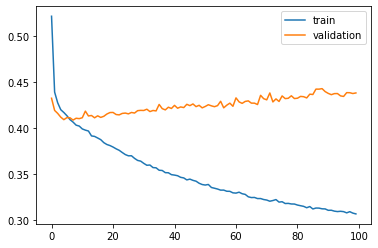

Entire process took:  111.80091381072998


In [29]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


num_per_fold = x_train.shape[0]//10
print(num_per_fold)

start_time = time.time()

n_units = 256
b_size = 256
dropout_rate_1 = 0.16882809594439618 #0.13712676510325922
dropout_rate_2 = 0.4992368718448247 #0.6614069627421949

for f in range(1):#10
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_mlp = np.append(train2_y, train1_y, axis=0)

    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = setup_model(n_units, 
                            dropout_rate_1, 
                            dropout_rate_2)
        v_loss, val_weight = fit_model(model, train_x_mlp, 
                           train_y_mlp, b_size)
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
print("Entire process took: ", time.time() - start_time)

In [30]:
print(yhat_test.shape)
yhat_v = scaler_y.inverse_transform(yhat_test)
yhat_df = pd.DataFrame(yhat_v)
print(yhat_df.shape)
yhat_df.columns = ["MEAN_TCHDL"]
feather.write_dataframe(yhat_df, "/home/whsu014/data/mean_TCHDL_MLP_yhat_100.feather")

(10096, 1)
(10096, 1)
